## Set up the drive path

In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [15]:
ls

adc.json  drive/  sample_data/


In [16]:
cd drive/atten_maxout

/content/drive/atten_maxout


## Import Library

In [0]:
import collections
import os
import sys

import tensorflow as tf
import numpy as np

from tensorflow.contrib.seq2seq import sequence_loss

import math
import re
import matplotlib.pyplot as plt

import pickle

!pip install -q mosestokenizer
from mosestokenizer import *

from nltk.translate.bleu_score import sentence_bleu


from scipy.stats import multivariate_normal
from scipy.stats import norm
import copy

## Data Pre-processing

In [0]:
## load vocab dict from txt file

f = open("../dictionary 2/en_word_to_id.txt", "rb")
en_word_to_id = pickle.load(f)
f.close()

f = open("../dictionary 2/fr_word_to_id.txt", "rb")
fr_word_to_id = pickle.load(f)
f.close()

In [19]:
en_vocab_size = len(en_word_to_id)
fr_vocab_size = len(fr_word_to_id)

en_eos = en_word_to_id['eos']
fr_eos = fr_word_to_id['eos']

print(en_vocab_size)
print(fr_vocab_size)

30772
39578


In [0]:
def _read_words(filename):
  with tf.gfile.GFile(filename, "r") as f: 
    output = f.read().replace("\n", " eos ").replace(".", " .")
    output = re.sub('[0-9]+', 'N', output)
    return output

def _file_to_word_ids(data, word_to_id):
  
  id_list = []
  
  for word in data:
    if word in word_to_id:
      id_list.append(word_to_id[word])
    else:
      id_list.append(1)
          
  return id_list


def preprocess_train_data(pre_data, word_to_id, max_length):
    pre_data_array = np.asarray(pre_data)
    last_start = 0
    data = []
    each_sen_len = []
    
    for i in range(len(pre_data_array)):
        if pre_data_array[i]==word_to_id['eos']:
            if max_length >= len(pre_data_array[last_start:(i+1)]):                
              data.append(pre_data_array[last_start:(i+1)])
              each_sen_len.append(i+1-last_start)              
            else:
              shorten_sentences = pre_data_array[last_start:(last_start+max_length-1)]
              shorten_sentences = np.concatenate((shorten_sentences, np.asarray([word_to_id['eos']])), axis=0)
              data.append(shorten_sentences)
              each_sen_len.append(max_length) 
            
            last_start = i+1
            
    out_sentences = np.full([len(data), max_length], word_to_id['<PAD>'], dtype=np.int32)
    for i in range(len(data)):
        out_sentences[i,:len(data[i])] = data[i]    
    return out_sentences, np.asarray(each_sen_len)

In [0]:
def generate_input_en(en_file, en_word_to_id, max_length):
  
    en_data = _read_words(en_file)

    en_tokenize = MosesTokenizer('en')

    en_data = en_tokenize(en_data)

    en_data_id = _file_to_word_ids(en_data, en_word_to_id)

    en_input, en_input_len = preprocess_train_data(en_data_id, en_word_to_id, max_length)
    
    return en_input, en_input_len
  
  
  
def generate_output_fr(fr_file, fr_word_to_id, max_length):
    
    fr_data = _read_words(fr_file)

    fr_tokenize = MosesTokenizer('fr')

    fr_data = fr_tokenize(fr_data)

    fr_data_id = _file_to_word_ids(fr_data, fr_word_to_id)

    fr_output, fr_output_len = preprocess_train_data(fr_data_id, fr_word_to_id,max_length=30)

    #out_beg_token = fr_word_to_id['<beg>']*np.ones((fr_output.shape[0], 1), dtype=np.int32)

    #fr_output = np.concatenate((out_beg_token, fr_output), axis=1)

    return fr_output,fr_output_len

In [0]:
def batch_producer(raw_data, raw_data_len, batch_size):    
    data_len = len(raw_data)    
    batch_len = data_len // batch_size    
    data = np.reshape(raw_data[0 : batch_size * batch_len, :], [batch_size, batch_len, -1])
    data = np.transpose(data, (1,0,2))
    
    data_length = np.reshape(raw_data_len[0 : batch_size * batch_len], [batch_size, batch_len])
    data_length = np.transpose(data_length, (1,0))
    return data, data_length 

In [0]:
en_oov_id = en_word_to_id['<OOV>']
fr_oov_id = fr_word_to_id['<OOV>']

def dropout_func(decode_input, dropout_prob, oov_id):
  for i in range(decode_input.shape[0]):
    for j in range(decode_input.shape[1]):
        for k in range(1,decode_input.shape[2]):
            if np.random.uniform() > dropout_prob:
                decode_input[i,j,k] = oov_id        
  return decode_input

## Model

In [0]:
###################### define parameters ######################

max_length = 30

batch_size = 100

embed_size = 300

infer_hidden_size = 1000

latent_size = 150

latent_num = 1

In [0]:
# ###################### generate sentence #######################
batch_size = 1

latent_num = 50

In [0]:
###################### define placeholder ######################

input_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'input')         # batch_size x max_length

target_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'target')       # batch_size x max_length

in_length_placeholder = tf.placeholder(tf.int32, [batch_size, ], 'in_len')              # batch_size x 1

out_length_placeholder = tf.placeholder(tf.int32, [batch_size, ], 'out_len')            # batch_size x 1

discount_placeholder = tf.placeholder(tf.float32, name='discount')

lr_placeholder = tf.placeholder(tf.float32, name='learn_rate')

input_drop_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'input_drop')   # batch_size x max_length

target_drop_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'target_drop') # batch_size x max_length

if_gene_placeholder = tf.placeholder(tf.bool, name='if_gene')

latent_var_placeholder = tf.placeholder(tf.float32, [latent_num, batch_size, max_length, latent_size], 'la_var')       # batch_size x max_length x latent_size

xavier_initializer = tf.contrib.layers.xavier_initializer()

In [0]:
##################### embedding look-up for input sentences ####################

with tf.variable_scope('en_embedding'):
    en_embedding = tf.get_variable('en_embeding',[en_vocab_size, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    inputs = tf.nn.embedding_lookup(en_embedding, input_placeholder)                      # batch_size x max_length x embed_size
    inputs_drop = tf.nn.embedding_lookup(en_embedding, input_drop_placeholder)                      # batch_size x max_length x embed_size
    

with tf.variable_scope('fr_embedding'):
    fr_embedding = tf.get_variable('fr_embeding',[fr_vocab_size, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    targets = tf.nn.embedding_lookup(fr_embedding, target_placeholder)                      # batch_size x max_length x embed_size
    targets_drop = tf.nn.embedding_lookup(fr_embedding, target_drop_placeholder)                      # batch_size x max_length x embed_size
    

## 1 Inference Model - Encoder

$q(z_1, z_2, ... , z_T|x,y)$

Similar to the encoder of RNNSearch

In [0]:
#################### Inference model  #######################

encode_inputs = tf.transpose(tf.concat([inputs, targets], axis=2), (1,0,2))

with tf.variable_scope('encode'):
    #basic_cell =tf.contrib.rnn.GRUCell(infer_hidden_size)
    basic_cell = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
    init_state = basic_cell.zero_state(batch_size, tf.float32)
    encode_outputs, encode_state = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell, 
                                                                   cell_bw=basic_cell, 
                                                                   inputs=encode_inputs,                                                                
                                                                   initial_state_fw=init_state,
                                                                   initial_state_bw=init_state,
                                                                   dtype=tf.float32,
                                                                   time_major=True)

In [0]:
#### encode_outputs: max_length x batch_size x infer_hidden_size

en_outputs = tf.concat((encode_outputs[0],encode_outputs[1]),2)                             # max_length x batch_size x 2*infer_hidden_size

en_outputs_tran = tf.transpose(en_outputs, (1,0,2))                                         # batch_size x en_max_length x 2*infer_hidden_size

en_outputs_resh = tf.reshape(en_outputs_tran, (batch_size*max_length, 2*infer_hidden_size))

In [0]:
# ##################### Inference model  #######################

# ##################### bi-direction lstm of source sentence ######################

# encode_inputs_x = tf.transpose(inputs, (1,0,2))  # en_max_length x batch_size x embed_size
  
# with tf.variable_scope('encode_x'):
#     basic_cell_x = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
#     init_state_x = basic_cell_x.zero_state(batch_size, tf.float32)
#     encode_outputs_x, encode_state_x = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell_x, 
#                                                                        cell_bw=basic_cell_x, 
#                                                                        inputs=encode_inputs_x,
#                                                                        sequence_length=in_length_placeholder,
#                                                                        initial_state_fw=init_state_x,
#                                                                        initial_state_bw=init_state_x,
#                                                                        dtype=tf.float32,
#                                                                        time_major=True)
# #### encode_outputs_x: max_length x batch_size x infer_hidden_size




# ##################### bi-direction lstm of target sentence ######################

# encode_inputs_y = tf.transpose(targets, (1,0,2))  # en_max_length x batch_size x embed_size
  
# with tf.variable_scope('encode_y'):
#     basic_cell_y = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
#     init_state_y = basic_cell_y.zero_state(batch_size, tf.float32)
#     encode_outputs_y, encode_state_y = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell_y, 
#                                                                        cell_bw=basic_cell_y, 
#                                                                        inputs=encode_inputs_y,
#                                                                        sequence_length=out_length_placeholder,
#                                                                        initial_state_fw=init_state_y,
#                                                                        initial_state_bw=init_state_y,
#                                                                        dtype=tf.float32,
#                                                                        time_major=True)
# #### encode_outputs_y: max_length x batch_size x infer_hidden_size

In [0]:
# #### encode_outputs: max_length x batch_size x infer_hidden_size

# en_outputs = tf.concat((encode_outputs[0],encode_outputs[1]),2)                             # max_length x batch_size x 2*infer_hidden_size

# en_outputs_tran = tf.transpose(en_outputs, (1,0,2))                                         # batch_size x en_max_length x 2*infer_hidden_size

# #en_outputs_resh = tf.reshape(en_outputs_tran, (batch_size*max_length, 2*infer_hidden_size)) # batch_size*max_length x 2*infer_hidden_size

# ##################### concatenate the state of encoder of x and y ######################

# fw_bw_en_state_x = tf.concat((encode_state_x[0][1],encode_state_x[1][1]),1)     # en_max_length x  2*infer_hidden_size

# fw_bw_en_state_y = tf.concat((encode_state_y[0][1],encode_state_y[1][1]),1)     # en_max_length x  2*infer_hidden_size

# fw_bw_en_state = tf.concat((fw_bw_en_state_x, fw_bw_en_state_y), 1)             # en_max_length x  4*infer_hidden_size

# fw_bw_en_state = tf.tile(tf.expand_dims(fw_bw_en_state, axis=1), (1,30,1))


# fw_bw_en = tf.concat((fw_bw_en_state, en_outputs_tran), axis=2)

# fw_bw_en = tf.reshape(fw_bw_en, (batch_size*max_length, 6*infer_hidden_size))

In [0]:
with tf.variable_scope('encode_projection'):
    W_1 = tf.get_variable('W_1',[2*infer_hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_1 = tf.get_variable('b_1',[latent_size,], dtype=tf.float32, initializer=xavier_initializer)
    W_2 = tf.get_variable('W_2',[2*infer_hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_2 = tf.get_variable('b_2',[latent_size,], dtype=tf.float32, initializer=xavier_initializer)

In [0]:
#fw_bw_en_outputs_norm = tf.contrib.layers.batch_norm(fw_bw_en_outputs_resh, center=True, scale=True)

la_mean = tf.matmul(en_outputs_resh, W_1) + b_1                              # batch_size*max_length x latent_size 

la_log_var = tf.matmul(en_outputs_resh, W_2) + b_2                           # batch_size*max_length x latent_size 
la_var = tf.exp(la_log_var)
la_std = tf.sqrt(la_var)

kl_div_loss = 1 + la_log_var - tf.square(la_mean) - la_var                      # batch_size*max_length x latent_size
kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, axis=1)                         # batch_size*max_length x 1
kl_div_loss = tf.reshape(kl_div_loss, (batch_size, max_length))                 # batch_size x max_length
kl_div_loss = tf.reduce_sum(kl_div_loss, axis=1)

In [0]:
# latent_variables_v = []
# for _ in range(latent_num):
#   eposida = tf.random_normal(tf.shape(la_std), mean=0.0,stddev=1)
#   latent_variables_sample = la_mean + la_std*eposida
#   latent_variables_sample = tf.reshape(latent_variables_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
#   latent_variables_v.append(latent_variables_sample)

# latent_variables = latent_variables_v

# def if_true():
#   latent_v = []
#   for h in range(latent_num):
#     latent_v.append(latent_var_placeholder[h])
#   return latent_v

# def if_false():
#   return latent_variables_v

# latent_variables = tf.cond(if_gene_placeholder, if_true, if_false)

# if latent_num == 1:
#   new_latent_variables = []
#   new_latent_variables.append(latent_variables)
#   latent_variables = new_latent_variables

In [0]:
latent_v = []
for h in range(latent_num):
  latent_v.append(latent_var_placeholder[h])
    
latent_variables = latent_v

## 2 Generation Model - Decoder

$p_\theta(x|z_1, z_2, ... , z_T)$

$p_\theta(y|z_1, z_2, ... , z_T)$

In [0]:
filter_num = 150

filter_size = 3

filter_size_only_pre = 2

filter_size_pad = filter_size - filter_size_only_pre

filter_zero_pad = tf.zeros(shape=[filter_size_pad, embed_size+latent_size, filter_num], dtype=tf.float32)
filter_zero_pad_2 = tf.zeros(shape=[1, filter_size_pad, filter_num, filter_num], dtype=tf.float32)

## X decoder

In [0]:
atten_size = 1000
maxout_size = 500

with tf.variable_scope('x_con_dialted_1D'):
  
    f_x_1 = tf.get_variable("x_filter_1", shape=[3, latent_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_1_dia = tf.concat([f_x_1, 
                           tf.zeros((2,latent_size+latent_size,filter_num))], axis=0)                                     
    # 3 x (embed_size+latent_size) x filter_num
    
    f_x_2 = tf.get_variable("x_filter_2", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_2_dia = tf.concat([tf.reshape(f_x_2[0],(1,filter_num,filter_num)), 
                           tf.zeros((1,filter_num,filter_num)), 
                           tf.reshape(f_x_2[1],(1,filter_num,filter_num)), 
                           tf.zeros((1,filter_num,filter_num)),
                           tf.reshape(f_x_2[2],(1,filter_num,filter_num)),
                           tf.zeros((4,filter_num,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_x_3 = tf.get_variable("x_filter_3", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_3_dia = tf.concat([tf.reshape(f_x_3[0],(1,filter_num,filter_num)), 
                           tf.zeros((3,filter_num,filter_num)), 
                           tf.reshape(f_x_3[1],(1,filter_num,filter_num)), 
                           tf.zeros((3,filter_num,filter_num)),
                           tf.reshape(f_x_3[2],(1,filter_num,filter_num)),
                           tf.zeros((8,filter_num,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_x_4 = tf.get_variable("x_filter_4", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_4_dia = tf.concat([tf.reshape(f_x_4[0],(1,filter_num,filter_num)), 
                           tf.zeros((7,filter_num,filter_num)), 
                           tf.reshape(f_x_4[1],(1,filter_num,filter_num)), 
                           tf.zeros((7,filter_num,filter_num)),
                           tf.reshape(f_x_4[2],(1,filter_num,filter_num)),
                           tf.zeros((16,filter_num,filter_num))], axis=0)
    # 21 x filter_num x filter_num

    
#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('projection_x'):
    proj_w_x = tf.get_variable('project_w_x', [maxout_size,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b_x = tf.get_variable('project_b_x', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
#### sequence weight of x
squence_weight_x= tf.sequence_mask(in_length_placeholder, maxlen=max_length, dtype=tf.float32)                       # batch_size x max_length

#### attention model ####
with tf.variable_scope('encode_projection_x'):
    U_a_x = tf.get_variable('U_a_x',[latent_size, atten_size], dtype=tf.float32, initializer=xavier_initializer)
    W_a_x = tf.get_variable('W_a_x',[embed_size, atten_size], dtype=tf.float32, initializer=xavier_initializer)
    V_a_x = tf.get_variable('V_a_x',[atten_size,1], dtype=tf.float32, initializer=xavier_initializer)
    
#### maxout model ####
with tf.variable_scope('x_probability'):
    U_o_x = tf.get_variable('U_o_x',[filter_num, 2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)
    V_o_x = tf.get_variable('V_o_x',[latent_size,  2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)
    C_o_x = tf.get_variable('C_o_x',[latent_size, 2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)

In [0]:
#beg_token_x = tf.zeros((1,embed_size))
beg_token_x = tf.reshape(en_embedding[en_eos], [1,embed_size])

x_list = tf.split(inputs, axis=0, num_or_size_splits=batch_size)

x_with_beg_list = [tf.concat((beg_token_x, input[0]), axis=0) for input in x_list]              # batch_size x (max_length+1) x embed_size

x_with_beg = tf.stack(x_with_beg_list, axis=0)

WaXi_1 = tf.matmul(tf.reshape(x_with_beg[:,:30,:], (batch_size*max_length, embed_size)), W_a_x)   # batch_size*max_length x atten_size

WaXi_1 = tf.reshape(WaXi_1, (batch_size, max_length, atten_size))                               #  batch_size x max_length x atten_size

In [0]:
def x_decoder(WaXi_1, de_latent):

  UaZj = tf.matmul(tf.reshape(de_latent, (batch_size*max_length, latent_size)), U_a_x)    # batch_size*max_length x atten_size

  context_c = []       # batch_size x max_length x latent_size

  for t in range(max_length):
    WaX0_allsteps = tf.tile(WaXi_1[:,t,:], (max_length,1)) # batch_size*max_length x atten_size

    e_1j = tf.reshape(tf.matmul(tf.nn.tanh(WaX0_allsteps + UaZj), V_a_x), (batch_size, max_length))
  
    alpha_1j = tf.nn.softmax(e_1j)
    alpha_1j_reshaped = tf.reshape(alpha_1j,(batch_size*max_length,1))         # batch_size*en_max_length x 1
  
    c_1j = alpha_1j_reshaped*tf.reshape(de_latent, (batch_size*max_length, latent_size))
    c_1 = tf.reduce_sum(tf.reshape(c_1j, (batch_size, max_length, latent_size)), axis=1)
  
    context_c.append(c_1)
  
  context_c = tf.stack(context_c, axis=1)
      
  x_out_conv_dia_1 = tf.nn.conv1d(tf.concat((de_latent, context_c), axis=2), 
                                  f_x_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1,
                                  f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, 
                                  f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, 
                                  f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  x_out_conv_dia = tf.reshape(x_out_conv_dia_4, (batch_size*max_length, filter_num))
  de_latent_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  context_c_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  
  #### Maxout layer
  tt_1 = tf.matmul(x_out_conv_dia, U_o_x) #+ tf.matmul(de_latent_resh, V_o_x) + tf.matmul(context_c_resh, C_o_x)       # batch_size*max_length x 2*maxout_size
  t_1 = tf.contrib.layers.maxout(tt_1,maxout_size,axis=-1)                                                      # batch_size*max_length x maxout_size
  
  x_out_project = tf.matmul(t_1, proj_w_x) + proj_b_x                                                           # batch_size*max_length x embed_size 
  
  target_x = tf.reduce_sum(x_out_project*tf.reshape(inputs, (batch_size*max_length, embed_size)), axis=1)
  logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))

  logits_x_re = tf.reshape(logits_x, (batch_size, max_length, en_vocab_size))                                   # batch_size x max_length x fr_vocab_size
  x_max = tf.reshape(tf.reduce_max(logits_x_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

  prob_unnorm_x = tf.exp(tf.reshape(target_x, (batch_size*max_length, 1)) - x_max)                                                                      # batch_size*max_length x 1
  prob_constant_x = tf.exp(logits_x - tf.tile(x_max,(1, en_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
  prob_norm_x = prob_unnorm_x/tf.reshape(tf.reduce_sum(prob_constant_x, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
  prob_norm_x = tf.reshape(prob_norm_x, (batch_size, max_length))                                                         # batch_size x max_length
  log_prob_norm_x = tf.log(tf.clip_by_value(prob_norm_x,1e-8,1.0))                                                        # batch_size x max_length

  log_liki_x = tf.reduce_sum(log_prob_norm_x*squence_weight_x, axis=1)                                                    # batch_size x 1
  return log_liki_x

log_liki_x_to = []
for l in range(latent_num):
  log_liki_x_to.append(x_decoder(WaXi_1,latent_variables[l]))
log_liki_x_to = tf.stack(log_liki_x_to, axis=0)
  

In [0]:
def x_decoder_gene(WaXi_1, de_latent):

  UaZj = tf.matmul(tf.reshape(de_latent, (batch_size*max_length, latent_size)), U_a_x)    # batch_size*max_length x atten_size

  context_c = []       # batch_size x max_length x latent_size

  for t in range(max_length):
    WaX0_allsteps = tf.tile(WaXi_1[:,t,:], (max_length,1)) # batch_size*max_length x atten_size

    e_1j = tf.reshape(tf.matmul(tf.nn.tanh(WaX0_allsteps + UaZj), V_a_x), (batch_size, max_length))
  
    alpha_1j = tf.nn.softmax(e_1j)
    alpha_1j_reshaped = tf.reshape(alpha_1j,(batch_size*max_length,1))         # batch_size*en_max_length x 1
  
    c_1j = alpha_1j_reshaped*tf.reshape(de_latent, (batch_size*max_length, latent_size))
    c_1 = tf.reduce_sum(tf.reshape(c_1j, (batch_size, max_length, latent_size)), axis=1)
  
    context_c.append(c_1)
  
  context_c = tf.stack(context_c, axis=1)
      
  x_out_conv_dia_1 = tf.nn.conv1d(tf.concat((de_latent, context_c), axis=2), 
                                  f_x_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1,
                                  f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, 
                                  f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, 
                                  f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  x_out_conv_dia = tf.reshape(x_out_conv_dia_4, (batch_size*max_length, filter_num))
  de_latent_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  context_c_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  
  #### Maxout layer
  tt_1 = tf.matmul(x_out_conv_dia, U_o_x) #+ tf.matmul(de_latent_resh, V_o_x) + tf.matmul(context_c_resh, C_o_x)       # batch_size*max_length x 2*maxout_size
  t_1 = tf.contrib.layers.maxout(tt_1,maxout_size,axis=-1)                                                      # batch_size*max_length x maxout_size
  
  x_out_project = tf.matmul(t_1, proj_w_x) + proj_b_x                                                           # batch_size*max_length x embed_size 
  
  logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))
  
  return logits_x

logits_gene_x_to = []
for l in range(latent_num):
  logits_gene_x_to.append(x_decoder_gene(WaXi_1,latent_variables[l]))
logits_gene_x_to = tf.stack(logits_gene_x_to, axis=0)

## Y decoder

In [0]:
with tf.variable_scope('y_con_dialted_1D'):
  
    f_y_1 = tf.get_variable("y_filter_1", shape=[3, latent_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_1_dia = tf.concat([f_y_1, 
                           tf.zeros((2, latent_size+latent_size,filter_num))], axis=0)  
                                    
    # 3 x (embed_size+latent_size) x filter_num
    
    f_y_2 = tf.get_variable("y_filter_2", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_2_dia = tf.concat([tf.reshape(f_y_2[0],(1,filter_num, filter_num)), 
                           tf.zeros((1,filter_num,filter_num)), 
                           tf.reshape(f_y_2[1],(1,filter_num,filter_num)), 
                           tf.zeros((1,filter_num,filter_num)),
                           tf.reshape(f_y_2[2],(1,filter_num,filter_num)),
                           tf.zeros((4,filter_num,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_y_3 = tf.get_variable("y_filter_3", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_3_dia = tf.concat([tf.reshape(f_y_3[0],(1,filter_num,filter_num)), 
                           tf.zeros((3,filter_num,filter_num)), 
                           tf.reshape(f_y_3[1],(1,filter_num,filter_num)), 
                           tf.zeros((3,filter_num,filter_num)),
                           tf.reshape(f_y_3[2],(1,filter_num,filter_num)),
                           tf.zeros((8,filter_num,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_y_4 = tf.get_variable("y_filter_4", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_4_dia = tf.concat([tf.reshape(f_y_4[0],(1,filter_num,filter_num)), 
                           tf.zeros((7,filter_num,filter_num)), 
                           tf.reshape(f_y_4[1],(1,filter_num,filter_num)), 
                           tf.zeros((7,filter_num,filter_num)),
                           tf.reshape(f_y_4[2],(1,filter_num,filter_num)),
                           tf.zeros((16,filter_num,filter_num))], axis=0)
    # 21 x filter_num x filter_num

    
    
#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('projection_y'):
    proj_w_y = tf.get_variable('project_w_y', [maxout_size,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b_y = tf.get_variable('project_b_y', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
    
#### sequence weight of y
squence_weight_y = tf.sequence_mask(out_length_placeholder, maxlen=max_length, dtype=tf.float32)                        # batch_size x max_length

#### attention model ####
with tf.variable_scope('encode_projection_y'):
    U_a_y = tf.get_variable('U_a_y',[latent_size, atten_size], dtype=tf.float32, initializer=xavier_initializer)
    W_a_y = tf.get_variable('W_a_y',[embed_size, atten_size], dtype=tf.float32, initializer=xavier_initializer)
    V_a_y = tf.get_variable('V_a_y',[atten_size,1], dtype=tf.float32, initializer=xavier_initializer)
    
#### maxout model ####
with tf.variable_scope('y_probability'):
    U_o_y = tf.get_variable('U_o_y',[filter_num, 2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)
    V_o_y = tf.get_variable('V_o_y',[latent_size,  2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)
    C_o_y = tf.get_variable('C_o_y',[latent_size, 2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)

In [0]:
#beg_token_x = tf.zeros((1,embed_size))
beg_token_y = tf.reshape(fr_embedding[fr_eos], [1,embed_size])

y_list = tf.split(targets, axis=0, num_or_size_splits=batch_size)

y_with_beg_list = [tf.concat((beg_token_y, target[0]), axis=0) for target in y_list]              # batch_size x (max_length+1) x embed_size

y_with_beg = tf.stack(y_with_beg_list, axis=0)

WaYi_1 = tf.matmul(tf.reshape(y_with_beg[:,:30,:], (batch_size*max_length, embed_size)), W_a_y)   # batch_size*max_length x atten_size

WaYi_1 = tf.reshape(WaYi_1, (batch_size, max_length, atten_size))                               #  batch_size x max_length x atten_size

In [0]:
def y_decoder(WaYi_1, de_latent):

  UaZj = tf.matmul(tf.reshape(de_latent, (batch_size*max_length, latent_size)), U_a_y)    # batch_size*max_length x atten_size

  context_c = []       # batch_size x max_length x latent_size

  for t in range(max_length):
    WaY0_allsteps = tf.tile(WaYi_1[:,t,:], (max_length,1)) # batch_size*max_length x atten_size

    e_1j = tf.reshape(tf.matmul(tf.nn.tanh(WaY0_allsteps + UaZj), V_a_y), (batch_size, max_length))
  
    alpha_1j = tf.nn.softmax(e_1j)
    alpha_1j_reshaped = tf.reshape(alpha_1j,(batch_size*max_length,1))         # batch_size*en_max_length x 1
  
    c_1j = alpha_1j_reshaped*tf.reshape(de_latent, (batch_size*max_length, latent_size))
    c_1 = tf.reduce_sum(tf.reshape(c_1j, (batch_size, max_length, latent_size)), axis=1)
  
    context_c.append(c_1)
  
  context_c = tf.stack(context_c, axis=1)
  
  y_out_conv_dia_1 = tf.nn.conv1d(tf.concat((de_latent, context_c), axis=2), 
                                  f_y_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_2 = tf.nn.conv1d(y_out_conv_dia_1, 
                                  f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_3 = tf.nn.conv1d(y_out_conv_dia_2,  
                                  f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_4 = tf.nn.conv1d(y_out_conv_dia_3,  
                                  f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  
  y_out_conv_dia = tf.reshape(y_out_conv_dia_4, (batch_size*max_length, filter_num))
  de_latent_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  context_c_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  
  #### Maxout layer
  tt_1 = tf.matmul(y_out_conv_dia, U_o_y) #+ tf.matmul(de_latent_resh, V_o_y) + tf.matmul(context_c_resh, C_o_y)       # batch_size*max_length x 2*maxout_size
  t_1 = tf.contrib.layers.maxout(tt_1,maxout_size,axis=-1)                                                      # batch_size*max_length x maxout_size
  
  y_out_project = tf.matmul(t_1, proj_w_y) + proj_b_y                                                           # batch_size*max_length x embed_size   
  
  
  target_y = tf.reduce_sum(y_out_project*tf.reshape(targets, (batch_size*max_length, embed_size)), axis=1)
  logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))

  logits_y_re = tf.reshape(logits_y, (batch_size, max_length, fr_vocab_size))                                   # batch_size x max_length x fr_vocab_size
  y_max = tf.reshape(tf.reduce_max(logits_y_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

  prob_unnorm_y = tf.exp(tf.reshape(target_y, (batch_size*max_length, 1)) - y_max)                              # batch_size*max_length x 1
  prob_constant_y = tf.exp(logits_y - tf.tile(y_max,(1, fr_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
  prob_norm_y = prob_unnorm_y/tf.reshape(tf.reduce_sum(prob_constant_y, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
  prob_norm_y = tf.reshape(prob_norm_y, (batch_size, max_length))                                                         # batch_size x max_length
  log_prob_norm_y = tf.log(tf.clip_by_value(prob_norm_y,1e-8,1.0))                                                        # batch_size x max_length

  log_liki_y = tf.reduce_sum(log_prob_norm_y*squence_weight_y, axis=1)                                                    # batch_size x 1
  return log_liki_y

log_liki_y_to = []
for l in range(latent_num):
  log_liki_y_to.append(y_decoder(WaYi_1,latent_variables[l]))
log_liki_y_to = tf.stack(log_liki_y_to, axis=0)
  

In [0]:
def y_decoder_gene(WaYi_1, de_latent):

  UaZj = tf.matmul(tf.reshape(de_latent, (batch_size*max_length, latent_size)), U_a_y)    # batch_size*max_length x atten_size

  context_c = []       # batch_size x max_length x latent_size

  for t in range(max_length):
    WaY0_allsteps = tf.tile(WaYi_1[:,t,:], (max_length,1)) # batch_size*max_length x atten_size

    e_1j = tf.reshape(tf.matmul(tf.nn.tanh(WaY0_allsteps + UaZj), V_a_y), (batch_size, max_length))
  
    alpha_1j = tf.nn.softmax(e_1j)
    alpha_1j_reshaped = tf.reshape(alpha_1j,(batch_size*max_length,1))         # batch_size*en_max_length x 1
  
    c_1j = alpha_1j_reshaped*tf.reshape(de_latent, (batch_size*max_length, latent_size))
    c_1 = tf.reduce_sum(tf.reshape(c_1j, (batch_size, max_length, latent_size)), axis=1)
  
    context_c.append(c_1)
  
  context_c = tf.stack(context_c, axis=1)
  
  y_out_conv_dia_1 = tf.nn.conv1d(tf.concat((de_latent, context_c), axis=2), 
                                  f_y_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_2 = tf.nn.conv1d(y_out_conv_dia_1, 
                                  f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_3 = tf.nn.conv1d(y_out_conv_dia_2,  
                                  f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_4 = tf.nn.conv1d(y_out_conv_dia_3,  
                                  f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  
  y_out_conv_dia = tf.reshape(y_out_conv_dia_4, (batch_size*max_length, filter_num))
  de_latent_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  context_c_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  
  #### Maxout layer
  tt_1 = tf.matmul(y_out_conv_dia, U_o_y) #+ tf.matmul(de_latent_resh, V_o_y) + tf.matmul(context_c_resh, C_o_y)       # batch_size*max_length x 2*maxout_size
  t_1 = tf.contrib.layers.maxout(tt_1,maxout_size,axis=-1)                                                      # batch_size*max_length x maxout_size
  
  y_out_project = tf.matmul(t_1, proj_w_y) + proj_b_y                                                           # batch_size*max_length x embed_size   
  
  logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))
  
  return logits_y

logits_gene_y_to = []
for l in range(latent_num):
  logits_gene_y_to.append(y_decoder_gene(WaYi_1,latent_variables[l]))
logits_gene_y_to = tf.stack(logits_gene_y_to, axis=0)

### 2.1 Generation Model for source sentence $p_\theta(x|z_1, z_2, ... , z_T)$


In [0]:
# #### concat beg token with input

# #beg_token_x = tf.zeros((1,embed_size))
# beg_token_x = tf.reshape(en_embedding[en_eos], [1,embed_size])

# x_list = tf.split(inputs, axis=0, num_or_size_splits=batch_size)

# x_with_beg_list = [tf.concat((beg_token_x, input[0]), axis=0) for input in x_list]              # batch_size x (max_length+1) x embed_size

# x_with_beg = tf.stack(x_with_beg_list, axis=0)

# #x_input_cnn_1 = tf.concat([latent_variables_1,x_with_beg[:,:30,:]], axis=2)                     # batch_size x max_length x (embed_size+latent_size)

# #x_input_cnn_2 = tf.concat([latent_variables_2,x_with_beg[:,:30,:]], axis=2)                     # batch_size x max_length x (embed_size+latent_size)

# #x_input_cnn_4D = tf.expand_dims(x_input_cnn, axis=1)                                        # batch_size x max_length x (embed_size+latent_size)

# x_input_cnn = []
# for l in range(latent_num):
#   x_input_cnn.append(tf.concat([latent_variables[l],x_with_beg[:,:30,:]], axis=2))

In [0]:
# with tf.variable_scope('x_con_dialted_1D'):
  
#     f_x_1 = tf.get_variable("x_filter_1", shape=[2, embed_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_1_dia = tf.concat([f_x_1, 
#                            tf.zeros((1,embed_size+latent_size,filter_num))], axis=0)                                     
#     # 3 x (embed_size+latent_size) x filter_num
    
#     f_x_2 = tf.get_variable("x_filter_2", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_2_dia = tf.concat([tf.reshape(f_x_2[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((1,filter_num+latent_size, filter_num)), 
#                            tf.reshape(f_x_2[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((1,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_x_2[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((4,filter_num+latent_size,filter_num)),], axis=0)
#     # 9 x filter_num x filter_num
    
#     f_x_3 = tf.get_variable("x_filter_3", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_3_dia = tf.concat([tf.reshape(f_x_3[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((3,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_x_3[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((3,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_x_3[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((8,filter_num+latent_size,filter_num))], axis=0)
#     # 13 x filter_num x filter_num
    
#     f_x_4 = tf.get_variable("x_filter_4", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_4_dia = tf.concat([tf.reshape(f_x_4[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((7,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_x_4[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((7,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_x_4[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((16,filter_num+latent_size,filter_num))], axis=0)
#     # 21 x filter_num x filter_num
    
# #     f_x_5 = tf.get_variable("x_filter_5", shape=[2, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
# #     f_x_5_dia = tf.concat([f_x_5, 
# #                            tf.zeros((1,filter_num+latent_size,filter_num))], axis=0)                                     
# #     # 3 x (embed_size+latent_size) x filter_num
    

    
# #### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
# with tf.variable_scope('projection_x'):
#     proj_w_x = tf.get_variable('project_w_x', [filter_num,embed_size], dtype=tf.float32, initializer=xavier_initializer)
#     proj_b_x = tf.get_variable('project_b_x', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
# #### sequence weight of x
# squence_weight_x= tf.sequence_mask(in_length_placeholder, maxlen=max_length, dtype=tf.float32)                       # batch_size x max_length

In [0]:
# def x_decoder(de_input, de_latent):
  
#   x_out_conv_dia_1 = tf.nn.conv1d(de_input, 
#                                   f_x_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_2 = tf.nn.conv1d(tf.concat((x_out_conv_dia_1, de_latent), axis=2),
#                                   f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_3 = tf.nn.conv1d(tf.concat((x_out_conv_dia_2, de_latent), axis=2), 
#                                   f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_4 = tf.nn.conv1d(tf.concat((x_out_conv_dia_3, de_latent), axis=2), 
#                                   f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
#   x_out_conv_dia = tf.reshape(x_out_conv_dia_4, (batch_size*max_length, filter_num))
  
#   x_out_project = tf.matmul(x_out_conv_dia, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
#   target_x = tf.reduce_sum(x_out_project*tf.reshape(inputs, (batch_size*max_length, embed_size)), axis=1)
#   logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))

#   logits_x_re = tf.reshape(logits_x, (batch_size, max_length, en_vocab_size))                                   # batch_size x max_length x fr_vocab_size
#   x_max = tf.reshape(tf.reduce_max(logits_x_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

#   prob_unnorm_x = tf.exp(tf.reshape(target_x, (batch_size*max_length, 1)) - x_max)                                                                      # batch_size*max_length x 1
#   prob_constant_x = tf.exp(logits_x - tf.tile(x_max,(1, en_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
#   prob_norm_x = prob_unnorm_x/tf.reshape(tf.reduce_sum(prob_constant_x, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
#   prob_norm_x = tf.reshape(prob_norm_x, (batch_size, max_length))                                                         # batch_size x max_length
#   log_prob_norm_x = tf.log(tf.clip_by_value(prob_norm_x,1e-8,1.0))                                                        # batch_size x max_length

#   log_liki_x = tf.reduce_sum(log_prob_norm_x*squence_weight_x, axis=1)                                                    # batch_size x 1
#   return log_liki_x

# log_liki_x_to = []
# for l in range(latent_num):
#   log_liki_x_to.append(x_decoder(x_input_cnn[l],latent_variables[l]))
# log_liki_x_to = tf.stack(log_liki_x_to, axis=0)

In [0]:
# def x_decoder_gene(de_input, latent_var):
  
#   x_out_conv_dia_1 = tf.nn.conv1d(de_input, f_x_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
#   x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1, f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_5 = tf.nn.conv1d(x_out_conv_dia_4, f_x_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
    
#   x_out_conv_dia = tf.reshape(x_out_conv_dia_5, (batch_size*max_length, filter_num))
#   x_out_gated_conv = x_out_conv_dia[:,:250]*tf.nn.sigmoid(x_out_conv_dia[:,250:])
  
#   x_out_project = tf.matmul(x_out_gated_conv, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
#   logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0))) 
#   return logits_x

# logits_gene_x_to = []
# for l in range(latent_num):
#   logits_gene_x_to.append(x_decoder_gene(x_input_cnn[l], latent_variables[l]))
# logits_gene_x_to = tf.stack(logits_gene_x_to, axis=0)

In [0]:
# def x_decoder_gene(de_input, latent_var):
  
#   x_out_conv_dia_1 = tf.nn.conv1d(de_input, f_x_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
#   x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1, f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_5 = tf.nn.conv1d(x_out_conv_dia_4, f_x_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
#   x_out_conv_dia = tf.reshape(x_out_conv_dia_5, (batch_size*max_length, filter_num))
#   x_out_project = tf.matmul(x_out_conv_dia, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
#   logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))
  
#   return logits_x

# logits_gene_x_to = []
# for l in range(latent_num):
#   logits_gene_x_to.append(x_decoder_gene(x_input_cnn[l]))
# logits_gene_x_to = tf.stack(logits_gene_x_to, axis=0)

### 2.2 Generation Model for target sentence $p_\theta(y|z_1, z_2, ... , z_T)$



In [0]:
# #### concat beg token with target

# #beg_token_y = tf.zeros((1,embed_size))
# beg_token_y = tf.reshape(fr_embedding[fr_eos], [1,embed_size])

# y_list = tf.split(targets, axis=0, num_or_size_splits=batch_size)

# y_with_beg_list = [tf.concat((beg_token_y, target[0]), axis=0) for target in y_list]              # batch_size x (max_length+1) x embed_size

# y_with_beg = tf.stack(y_with_beg_list, axis=0)

# y_input_cnn = []
# for l in range(latent_num):
#   y_input_cnn.append(tf.concat([latent_variables[l],y_with_beg[:,:30,:]], axis=2))

In [0]:
# with tf.variable_scope('y_con_dialted_1D'):
  
#     f_y_1 = tf.get_variable("y_filter_1", shape=[2, embed_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_1_dia = tf.concat([f_y_1, 
#                            tf.zeros((1,embed_size+latent_size,filter_num))], axis=0)  
                                    
#     # 3 x (embed_size+latent_size) x filter_num
    
#     f_y_2 = tf.get_variable("y_filter_2", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_2_dia = tf.concat([tf.reshape(f_y_2[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((1,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_y_2[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((1,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_y_2[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((4,filter_num+latent_size,filter_num)),], axis=0)
#     # 9 x filter_num x filter_num
    
#     f_y_3 = tf.get_variable("y_filter_3", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_3_dia = tf.concat([tf.reshape(f_y_3[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((3,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_y_3[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((3,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_y_3[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((8,filter_num+latent_size,filter_num))], axis=0)
#     # 13 x filter_num x filter_num
    
#     f_y_4 = tf.get_variable("y_filter_4", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_4_dia = tf.concat([tf.reshape(f_y_4[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((7,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_y_4[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((7,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_y_4[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((16,filter_num+latent_size,filter_num))], axis=0)
#     # 21 x filter_num x filter_num

    
    
# #### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
# with tf.variable_scope('projection_y'):
#     proj_w_y = tf.get_variable('project_w_y', [filter_num,embed_size], dtype=tf.float32, initializer=xavier_initializer)
#     proj_b_y = tf.get_variable('project_b_y', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
    
# #### sequence weight of y
# squence_weight_y = tf.sequence_mask(out_length_placeholder, maxlen=max_length, dtype=tf.float32)                        # batch_size x max_length

In [0]:
# def y_decoder(de_input,de_latent):
  
#   y_out_conv_dia_1 = tf.nn.conv1d(de_input, 
#                                   f_y_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
#   y_out_conv_dia_2 = tf.nn.conv1d(tf.concat((y_out_conv_dia_1, de_latent), axis=2), 
#                                   f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   y_out_conv_dia_3 = tf.nn.conv1d(tf.concat((y_out_conv_dia_2, de_latent), axis=2), 
#                                   f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   y_out_conv_dia_4 = tf.nn.conv1d(tf.concat((y_out_conv_dia_3, de_latent), axis=2), 
#                                   f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
#   y_out_conv_dia = tf.reshape(y_out_conv_dia_4, (batch_size*max_length, filter_num))
  
#   y_out_project = tf.matmul(y_out_conv_dia, proj_w_y) + proj_b_y 
                                        

#   target_y = tf.reduce_sum(y_out_project*tf.reshape(targets, (batch_size*max_length, embed_size)), axis=1)
#   logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))

#   logits_y_re = tf.reshape(logits_y, (batch_size, max_length, fr_vocab_size))                                   # batch_size x max_length x fr_vocab_size
#   y_max = tf.reshape(tf.reduce_max(logits_y_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

#   prob_unnorm_y = tf.exp(tf.reshape(target_y, (batch_size*max_length, 1)) - y_max)                              # batch_size*max_length x 1
#   prob_constant_y = tf.exp(logits_y - tf.tile(y_max,(1, fr_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
#   prob_norm_y = prob_unnorm_y/tf.reshape(tf.reduce_sum(prob_constant_y, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
#   prob_norm_y = tf.reshape(prob_norm_y, (batch_size, max_length))                                                         # batch_size x max_length
#   log_prob_norm_y = tf.log(tf.clip_by_value(prob_norm_y,1e-8,1.0))                                                        # batch_size x max_length

#   log_liki_y = tf.reduce_sum(log_prob_norm_y*squence_weight_y, axis=1)                                                    # batch_size x 1
#   return log_liki_y

# log_liki_y_to = []
# for l in range(latent_num):
#   log_liki_y_to.append(y_decoder(y_input_cnn[l],latent_variables[l]))
# log_liki_y_to = tf.stack(log_liki_y_to, axis=0)

### The lower bound of log-joint-likelihood, to maximize

In [0]:
nega_log_liki_x_y = 0

nega_elbo = 0

for l in range(latent_num):
  nega_log_liki_x_y = nega_log_liki_x_y + tf.reduce_mean(- log_liki_x_to[l] - log_liki_y_to[l])
  nega_elbo = nega_elbo - log_liki_x_to[l] - log_liki_y_to[l]
  
nega_log_liki_x_y = nega_log_liki_x_y/latent_num
nega_elbo = nega_elbo/latent_num + discount_placeholder*kl_div_loss
objective = tf.reduce_mean(nega_elbo) 
kl_div_loss_batch_mean = tf.reduce_mean(kl_div_loss)

In [0]:
# L2 reguralization for trainable variables
#train_variables = tf.trainable_variables()
#regularization_cost = tf.reduce_sum([tf.nn.l2_loss(variable) for variable in train_variables])
#regular_rate = 0.00001
#+ regular_rate*regularization_cost

In [0]:
# optimizer = tf.train.AdamOptimizer(lr_placeholder)

# gvs, var = zip(*optimizer.compute_gradients(objective))

# #checked_gvs = [tf.where(tf.is_nan(grad), tf.zeros_like(grad), grad) for grad in gvs]

# cliped_gvs, _ = tf.clip_by_global_norm(gvs, 1)

# opt = optimizer.apply_gradients(zip(cliped_gvs, var))

In [0]:
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#gvs = optimizer.compute_gradients(objective)
#capped_gvs = [(tf.clip_by_norm(grad, 1), var) for grad, var in gvs]
#opt = optimizer.apply_gradients(capped_gvs)

In [0]:
#### save the model
def save_model(session, path):
    if not os.path.exists("./result_0827/"):
        os.mkdir('./result_0827/')
    saver = tf.train.Saver()
    saver.save(session, path)

path1 = './result_0827/model_each_epch.ckpt'

## Training 

In [0]:
def sigmoid(x):
    return (1 / (1 + math.exp(-x)))


def text_save(content,filename,mode='a'):
    # Try to save a list variable in txt file.
    file = open(filename,mode)
    for i in range(len(content)):
        file.write(str(content[i])+'\n')
    file.close()
    
def text_read(filename):
    # Try to read a txt file and return a list.Return [] if there was a mistake.
    try:
        file = open(filename,'r')
    except IOError:
        error = []
        return error
    content = file.readlines()
 
    for i in range(len(content)):
        content[i] = content[i][:len(content[i])-1]
 
    file.close()
    return content

In [0]:
max_epochs = 5
total_step = 0
learning_rate = 0.001

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))
elbo_results=[]
kl_results = []
likei_results = []


init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    for epoc in range(max_epochs):
      
        print("learning rate")
        print(learning_rate)
      
        print('Epoch {}'.format(epoc))

        ind_small_txt = epoc
        
        en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
        fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
        print(en_file)
        print(fr_file)
        
        en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
        fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

        en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
        fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
#         en_input_drop_batches = dropout_func(en_input_batches, 0.7, en_oov_id)
#         fr_output_drop_batches = dropout_func(fr_output_batches, 0.7, fr_oov_id)
        
        en_input_drop_batches = en_input_batches
        fr_output_drop_batches = fr_output_batches
        
                       
        batch_len = en_input_batches.shape[0]
        
        ########### training ###########
        for i in range(batch_len):
          
            #discount_rate = sigmoid(0.0025*(total_step-2500))
            discount_rate = 0.0002*total_step
            if discount_rate >1:
              discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         lr_placeholder: learning_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti,  _ = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective, opt], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
              
            if i%100 == 0:
              print(kl)
              print(nage_likeli)
              print(objecti)
              print(discount_rate)
              
              print(llx_mean)
              print(lly_mean)
 
              elbo_results.append(objecti)
              kl_results.append(kl)
              likei_results.append(nage_likeli)
            
            total_step = total_step + 1
            
        save_model(sess, path1)
        
text_save(elbo_results, './result_0827/elbo_results.txt')
text_save(kl_results, './result_0827/kl_results.txt')
text_save(likei_results, './result_0827/likei_results.txt')

In [0]:
max_epochs = 5
learning_rate = 0.001
total_step = 0
zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))
elbo_results=[]
kl_results = []
likei_results = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for epoc in range(max_epochs):
      
        print("learning rate")
        print(learning_rate)
      
        print('Epoch {}'.format(epoc))

        ind_small_txt = epoc + 5
        
        en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
        fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
        print(en_file)
        print(fr_file)
        
        en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
        fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

        en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
        fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
        en_input_drop_batches = en_input_batches
        fr_output_drop_batches = fr_output_batches
                       
        batch_len = en_input_batches.shape[0]
        
        ########### training ###########
        for i in range(batch_len):
          
            #discount_rate = 0.0002*total_step
            #if discount_rate >1:
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         lr_placeholder: learning_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti,  _ = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective, opt], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
              
            if i%100 == 0:
              print(kl)
              print(nage_likeli)
              print(objecti)
              print(discount_rate)
              
              print(llx_mean)
              print(lly_mean)
 
              elbo_results.append(objecti)
              kl_results.append(kl)
              likei_results.append(nage_likeli)
            
            total_step = total_step + 1
            
        save_model(sess, path1)

text_save(elbo_results, './result_0827/elbo_results.txt')
text_save(kl_results, './result_0827/kl_results.txt')
text_save(likei_results, './result_0827/likei_results.txt')

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt
learning rate
0.001
Epoch 0
../small_txt/5_en.txt
../small_txt/5_fr.txt
88.00195
118.50188
206.50383
1
60.067104
58.43478
94.82827
125.11245
219.94072
1
65.51787
59.594585
96.83912
126.544426
223.38356
1
66.62332
59.921097
99.121864
132.78278
231.90463
1
69.32318
63.459595
98.675354
128.3542
227.02956
1
67.92458
60.42961
92.270226
120.95975
213.22997
1
63.962944
56.996796
98.31989
128.4535
226.77339
1
67.29732
61.15618
91.90546
115.60121
207.50665
1
59.90189
55.699326
95.65855
118.224144
213.88268
1
62.05914
56.16501
97.58465
128.43816
226.0228
1
67.31044
61.127716
99.4332
132.79594
232.22914
1
70.10253
62.69341
98.52193
129.53596
228.05789
1
67.99583
61.54015
97.067535
124.05039
221.11795
1
66.256195
57.794205
95.21031
117.723206
212.93353
1
60.902565
56.820633
96.56882
129.60023
226.16907
1
67.15755
62.44269
learning rate
0.001
Epoch 1
../small_txt/6_en.txt
../small_txt/6_fr.txt
94.668304
126.81277
221.48105

## Load test data and test the model

### Test 1

In [0]:
################################################################################
######################## load test data ########################################
################################################################################

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

kl_test_1 = []
nage_likeli_test_1 = []
objecti_test_1 = []
llx_test_1 = []
lly_test_1 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)   

    ind_small_txt = 12
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
                           
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_1.append(kl)
            nage_likeli_test_1.append(nage_likeli)
            objecti_test_1.append(objecti)
            llx_test_1.append(llx_mean)
            lly_test_1.append(lly_mean)


print(np.mean(kl_test_1))
print(np.mean(nage_likeli_test_1))
print(np.mean(objecti_test_1))
print(np.mean(llx_test_1))
print(np.mean(lly_test_1))

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt
94.73441
134.34508
229.07947
68.76233
65.58274


### Test 2

In [0]:
################################################################################
######################## load test data ########################################
################################################################################

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

kl_test_2 = []
nage_likeli_test_2 = []
objecti_test_2 = []
llx_test_2 = []
lly_test_2 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)   

    ind_small_txt = 11
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
                       
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_2.append(kl)
            nage_likeli_test_2.append(nage_likeli)
            objecti_test_2.append(objecti)
            llx_test_2.append(llx_mean)
            lly_test_2.append(lly_mean)


print(np.mean(kl_test_2))
print(np.mean(nage_likeli_test_2))
print(np.mean(objecti_test_2))
print(np.mean(llx_test_2))
print(np.mean(lly_test_2))

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt
94.63166
134.99571
229.62738
69.32357
65.67215


### Test 3

In [0]:
################################################################################
######################## load test data ########################################
################################################################################

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

kl_test_2 = []
nage_likeli_test_2 = []
objecti_test_2 = []
llx_test_2 = []
lly_test_2 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)   

    ind_small_txt = 10
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
                       
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_2.append(kl)
            nage_likeli_test_2.append(nage_likeli)
            objecti_test_2.append(objecti)
            llx_test_2.append(llx_mean)
            lly_test_2.append(lly_mean)


print(np.mean(kl_test_2))
print(np.mean(nage_likeli_test_2))
print(np.mean(objecti_test_2))
print(np.mean(llx_test_2))
print(np.mean(lly_test_2))

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt
96.2272
133.75565
229.98282
68.707146
65.0485


### Sub-Train Set

In [0]:
zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

kl_test_3 = []
nage_likeli_test_3 = []
objecti_test_3 = []
llx_test_3 = []
lly_test_3 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)   

    ind_small_txt = 6
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
                       
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_3.append(kl)
            nage_likeli_test_3.append(nage_likeli)
            objecti_test_3.append(objecti)
            llx_test_3.append(llx_mean)
            lly_test_3.append(lly_mean)


print(np.mean(kl_test_3))
print(np.mean(nage_likeli_test_3))
print(np.mean(objecti_test_3))
print(np.mean(llx_test_3))
print(np.mean(lly_test_3))

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt
94.54011
121.75517
216.29527
62.96242
58.792747


## Numerical Results

Text(0.5,1,'Encoder_2_GDCNN_300_dropout_0.8')

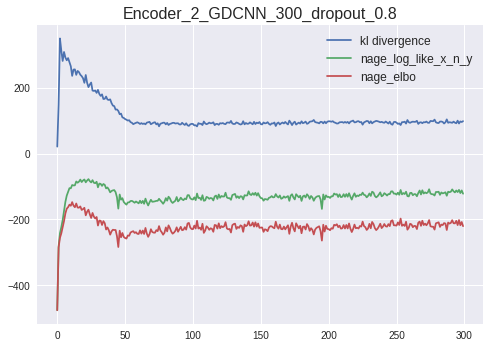

In [0]:
elbo_read = text_read('./result_0827/elbo_results.txt')
elbo_read = [-float(elbo) for elbo in elbo_read]

kl_read = text_read('./result_0827/kl_results.txt')
kl_read = [float(kl) for kl in kl_read]

likei_read = text_read('./result_0827/likei_results.txt')
likei_read = [-float(likei) for likei in likei_read]

plt.plot(kl_read, color = 'C0')
plt.plot(likei_read, color = 'C1')
plt.plot(elbo_read, color = 'C2')
plt.legend(['kl divergence','nage_log_like_x_n_y', 'nage_elbo'], fontsize=12)
plt.title("Encoder_2_GDCNN_300_dropout_0.8", fontsize=16)

## Generate sentence

In [0]:
ind_small_txt =  6
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)

### Define functions

In [0]:
def find_next_word_beam_gene(logits_y, t):

  lower_ob = []
  for l in range(latent_num):           
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l] 
  lower_ave = lower_to/latent_num
  
  return lower_ave

In [0]:
def id_to_word(words, word_to_id, max_length):
  k=0
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
      if words[p] == word_to_id['eos'] and k==0:
        sen_len = p
        k=k+1
  return sens, sen_len

def output_sentence(idd,x_de,y_de):
  ########## "English" ##########
  origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("x:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("x_re:")
  print(or_sens_str)
  
  en_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(0.25, 0.25, 0.25, 0.25))
  print(en_bleu)
  
  ########## "French" ##########
  origin_sens, ori_len = id_to_word(fr_output[idd], fr_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("y:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(y_de[-1], fr_word_to_id, 30)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("y_re:")
  print(or_sens_str)
  
  fr_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(0.25, 0.25, 0.25, 0.25))
  print(fr_bleu)
  return en_bleu, fr_bleu
  
def obleu_sentence(idd,x_de,y_de):
  ########## "English" ##########
  origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
  or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
  en_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(0.25, 0.25, 0.25, 0.25))
  print(en_bleu)
  
  ########## "French" ##########
  origin_sens, ori_len = id_to_word(fr_output[idd], fr_word_to_id, max_length)
  or_sens, or_len = id_to_word(y_de[-1], fr_word_to_id, 30)
  fr_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(0.25, 0.25, 0.25, 0.25))
  print(fr_bleu)
  
  return en_bleu, fr_bleu

### Case 9 \ 64 \ 68 \ 77 \ 78 \ 99

In [0]:
output_sentence(9,x_de,y_de)

x:
  I appeal for an in @-@ depth debate on this subject .
x_re:
  I call for this in this depth debate on this subject .
0.75
y:
  Je demande qu&apos; un débat approfondi soit mené sur ce sujet .
y_re:
  Je demande qu&apos; un débat européen a positif à ce sujet .
0.6666666666666666


In [0]:
output_sentence(64,x_de,y_de)

x:
  I also wish to thank Mr Almunia for the assistance he has given Cyprus all this time in achieving this objective .
x_re:
  I also like to thank Mr Barnier for the fact , has on it and this time in the this objective .
0.6363636363636364


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Je voudrais également remercier M . Almunia pour l&apos; aide qu&apos; il a apportée à Chypre pendant tout ce temps en vue d&apos; atteindre cet objectif .
y_re:
  Je voudrais également remercier M . Andor pour l&apos; importance qu&apos; il a apportée à Cancún dans tout un rapport en vue d&apos; atteindre un accord .
0.7037037037037037


In [0]:
output_sentence(89,x_de,y_de)

x:
  It is a mechanism that we have criticised here , in this Parliament , and that , I think , we continue to criticise .
x_re:
  It is a matter that we have heard here , in this House , and that , I think , we continue to say .
0.84
y:
  C&apos; est un mécanisme que nous avons critiqué ici , dans ce Parlement , et que , je pense , nous continuons de critiquer .
y_re:
  C&apos; est un sujet de nous avons fait , , dans ce Parlement , et , , je pense , nous sûr de suivre .
0.72


In [0]:
output_sentence(77,x_de,y_de)

x:
  The issue of the euro is no small matter for our fellow citizens : it is , in their hands , one of the European Union &apos;s most valuable
x_re:
  The issue of the euro is no an issue in the fellow citizens , it is , in their hands , one of the European Union &apos;s most important
0.7931034482758621
y:
  L&apos; affaire de l&apos; euro n&apos; est pas une petite affaire pour nos concitoyens : c&apos; est , entre leurs mains , un des biens les plus précieux de
y_re:
  L&apos; année de l&apos; euro n&apos; est pas une grande fois pour nos concitoyens , c&apos; est que sans les mains , un des
0.642782940702586


In [0]:
output_sentence(78,x_de,y_de)

x:
  Since last year , however , since the opening of the debate on the accession of Lithuania , we have had the impression that it has become a debate
x_re:
  In that year , however , and the outcome of the debate on the accession of Bulgaria , we have had the impression that it has been a problem
0.7586206896551724
y:
  Pourtant , depuis l&apos; année dernière , depuis l&apos; ouverture du débat sur l&apos; adhésion de la Lituanie , nous avons l&apos; impression qu&apos; il est devenu un débat
y_re:
  Mais , après l&apos; année dernière , après l&apos; année du débat sur l&apos; adhésion de la Bulgarie , nous avons l&apos; impression qu&apos; il est toujours un problème
0.7586206896551724


### Beam Search

In [51]:
########## Beam Search gene x ###########
x_bleu = []
y_bleu = []

with tf.Session() as sess:
  
  saver = tf.train.Saver()
  saver.restore(sess, path1)
  
  for idd in range(20):
  
    beam_size = 30
    decode_len = 30

    eos_id = en_word_to_id['eos']
    eos_prob = -float('Inf')

    x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
    y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))

    x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))
    y_de = np.random.randint(low=0, high=fr_vocab_size, size=(beam_size, max_length))

    x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
    y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

    #########################################################
    x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
    x_de_new = np.zeros(x_de.shape, dtype=np.int32)
    x_score = np.zeros((beam_size))

    y_prob_next_word = np.ones((beam_size, fr_vocab_size),dtype=np.float32)
    y_de_new = np.zeros(y_de.shape, dtype=np.int32)
    y_score = np.zeros((beam_size))

    #########################################################
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
       
    for t in range(decode_len):
      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length)),
                            target_placeholder: np.reshape(y_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          logits_y = sess.run(logits_gene_y_to, feed_dict=gene_feed_dict)
            
          x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
          
          x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
          y_prob_next_word[j] = find_next_word_beam_gene(logits_y, t)          
          
          y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
        
        
        x_beam_id = np.argmax(x_prob_next_word, axis=0)
        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)
        
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
        
        y_beam_id = np.argmax(y_prob_next_word, axis=0)
        
        y_prob_next_word_beam = np.max(y_prob_next_word, axis=0)
        
        y_next_word_id = np.argsort(y_prob_next_word_beam[2:])[-beam_size:] + 2
        
        
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
          
          
          y_beam_id_j = y_beam_id[y_next_word_id[j]]
          
          y_word_id_j = y_next_word_id[j]
          
          y_de_new[j] = copy.deepcopy(y_de[y_beam_id_j])
              
          y_de_new[j,t] = copy.deepcopy(y_word_id_j)
          
          y_score[j] = copy.deepcopy(y_prob_next_word_beam[y_word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        y_de = copy.deepcopy(y_de_new)
  
    en_le, fr_le = output_sentence(idd,x_de,y_de)
    x_bleu.append(en_le)
    y_bleu.append(fr_le)

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


x:
  In fact , quite the opposite is the case .
x_re:
  In fact , , the opposite for the case .
0.5773502691896258


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  En réalité , c&apos; est même plutôt l&apos; inverse .
y_re:
  En réalité , c&apos; est tout dans l&apos; inverse .
0.5253819788848316
x:
  It reflects the fact that the new Member States are catching up with the developed economies of the old Union .
x_re:
  It is the fact that the European Member States are set up with the respective regions of the European Union .
0.2476165058078653
y:
  Cela montre que les nouveaux États membres rattrapent les économies développées de la &quot; vieille &quot; Union .
y_re:
  Cela montre que les les États membres et des économies importantes de la la et &quot; européenne .
0.20105373454060027
x:
  Thirdly , I would like to draw your attention to the fact that the definition of stability applied by the Commission and the European Central Bank in convergence reports
x_re:
  Lastly , I would like to draw your attention to the fact that the creation of transparency . by the EU and the European Union Bank in Europe ,
0.5157115350821027
y:
  Troisièm

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Toujours est @-@ il que le texte du Traité ne contient qu&apos; une seule définition de la stabilité des prix et que nous ne pouvons avoir deux interprétations différentes
y_re:
  Il est @-@ il que le texte du règlement ne est qu&apos; une la efficace de la politique des
0.22844993462524102
x:
  The inflation criteria currently means that some of the new Member States may not be able to join the eurozone for many years .
x_re:
  The financing of , means that some of the new Member States should not be able to use the euro in the years .
0.42662196623863147
y:
  Le critère de l&apos; inflation fait que certains des nouveaux États membres ne pourront peut @-@ être pas rejoindre la zone euro avant de nombreuses années .
y_re:
  Le rapport de l&apos; Europe montre que N les nouveaux États membres ne peuvent peut @-@ être pas pas la zone euro et de nombreuses années .
0.3265250050211476
x:
  This permanently divides the Member States into two categories , namely the eurozone countries 

In [56]:
########## Beam Search gene x ###########
x_bleu = []
y_bleu = []

with tf.Session() as sess:
  
  saver = tf.train.Saver()
  saver.restore(sess, path1)
  
  for idd in range(20,50):
  
    beam_size = 30
    decode_len = 30

    eos_id = en_word_to_id['eos']
    eos_prob = -float('Inf')

    x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
    y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))

    x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))
    y_de = np.random.randint(low=0, high=fr_vocab_size, size=(beam_size, max_length))

    x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
    y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

    #########################################################
    x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
    x_de_new = np.zeros(x_de.shape, dtype=np.int32)
    x_score = np.zeros((beam_size))

    y_prob_next_word = np.ones((beam_size, fr_vocab_size),dtype=np.float32)
    y_de_new = np.zeros(y_de.shape, dtype=np.int32)
    y_score = np.zeros((beam_size))

    #########################################################
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
       
    for t in range(decode_len):
      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length)),
                            target_placeholder: np.reshape(y_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          logits_y = sess.run(logits_gene_y_to, feed_dict=gene_feed_dict)
            
          x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
          
          x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
          y_prob_next_word[j] = find_next_word_beam_gene(logits_y, t)          
          
          y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
        
        
        x_beam_id = np.argmax(x_prob_next_word, axis=0)
        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)
        
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
        
        y_beam_id = np.argmax(y_prob_next_word, axis=0)
        
        y_prob_next_word_beam = np.max(y_prob_next_word, axis=0)
        
        y_next_word_id = np.argsort(y_prob_next_word_beam[2:])[-beam_size:] + 2
        
        
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
          
          
          y_beam_id_j = y_beam_id[y_next_word_id[j]]
          
          y_word_id_j = y_next_word_id[j]
          
          y_de_new[j] = copy.deepcopy(y_de[y_beam_id_j])
              
          y_de_new[j,t] = copy.deepcopy(y_word_id_j)
          
          y_score[j] = copy.deepcopy(y_prob_next_word_beam[y_word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        y_de = copy.deepcopy(y_de_new)
  
    en_le, fr_le = output_sentence(idd,x_de,y_de)
    x_bleu.append(en_le)
    y_bleu.append(fr_le)

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


x:
  Since its entry into ERM II , the European exchange rate mechanism , the Cypriot pound has been exchanged in a stable manner at a satisfactory exchange rate .
x_re:
  In the entry into force II , the European exchange of &apos; , the European report has been used in a comprehensive , in a significant impact , .
0.18852104513558068
y:
  Depuis son entrée dans le mécanisme de change II , la livre chypriote a été échangée de manière relativement stable à un taux de change satisfaisant .
y_re:
  Pour son qui , le cadre de Bâle II , la &quot; &quot; a été créé de manière plus &quot; à un moment de risque , .
0.25130737267754294


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


x:
  In the last N months the average long @-@ term interest rate has been N .N % , which is below the reference value of N .N % .
x_re:
  In the past N years the more part @-@ term amount , has been N .N % , which is not the biggest value of N .N % may
0.4117230572911877
y:
  Le taux d&apos; intérêt à long terme s&apos; établit à N , N % pour les douze derniers mois , ce qui se situe nettement sous la valeur de
y_re:
  Le nombre d&apos; ajustement à long terme qui N de N de N % pour les N États membres , ce qui se trouve , dans la N aux
0.2210097542933647
x:
  The Cypriot economy is highly integrated into the European Union &apos;s economy .
x_re:
  The European economy is very open in the European Union &apos;s economy .
0.44082318755867267
y:
  L&apos; économie chypriote est étroitement intégrée dans celle de l&apos; Union européenne .
y_re:
  L&apos; économie européenne est devenue importante dans celle de l&apos; Union européenne .
0.5344445934790545
x:
  The Commission considers 

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Les statistiques le confirment .
y_re:
  Les études le fait .
0.8801117367933934


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


x:
  In N , public debt in the countries of the old European Union was as high as N .N % of GDP and , in as many as half
x_re:
  In N , economic debt in the countries of the European European Union is is far for N .N % of GDP , , and as well , many
0.3602421475072493
y:
  En N , la dette publique des pays de la &quot; vieille &quot; Union européenne s&apos; élevait à N , N % du PIB et dans pas moins de
y_re:
  En N , la crise publique des travailleurs de la mer européenne et Union européenne s&apos; élevait à N de N % du PIB , dans
0.3765151846638952
x:
  Thirdly , the Commission &apos;s attitude towards countries wishing to join the eurozone varies greatly .
x_re:
  Thirdly , the Commission &apos;s work on women needs to join the EU are themselves .
0.31535540524901323
y:
  Troisièmement , l&apos; attitude de la Commission à l&apos; égard des pays qui souhaitent rejoindre la zone euro varie énormément d&apos; un pays à l&apos; autre .
y_re:
  Enfin , l&apos; importance de la Commissio

In [54]:
########## Beam Search gene x ###########
x_bleu = []
y_bleu = []

with tf.Session() as sess:
  
  saver = tf.train.Saver()
  saver.restore(sess, path1)
  
  for idd in range(50,75):
  
    beam_size = 30
    decode_len = 30

    eos_id = en_word_to_id['eos']
    eos_prob = -float('Inf')

    x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
    y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))

    x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))
    y_de = np.random.randint(low=0, high=fr_vocab_size, size=(beam_size, max_length))

    x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
    y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

    #########################################################
    x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
    x_de_new = np.zeros(x_de.shape, dtype=np.int32)
    x_score = np.zeros((beam_size))

    y_prob_next_word = np.ones((beam_size, fr_vocab_size),dtype=np.float32)
    y_de_new = np.zeros(y_de.shape, dtype=np.int32)
    y_score = np.zeros((beam_size))

    #########################################################
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
       
    for t in range(decode_len):
      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length)),
                            target_placeholder: np.reshape(y_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          logits_y = sess.run(logits_gene_y_to, feed_dict=gene_feed_dict)
            
          x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
          
          x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
          y_prob_next_word[j] = find_next_word_beam_gene(logits_y, t)          
          
          y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
        
        
        x_beam_id = np.argmax(x_prob_next_word, axis=0)
        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)
        
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
        
        y_beam_id = np.argmax(y_prob_next_word, axis=0)
        
        y_prob_next_word_beam = np.max(y_prob_next_word, axis=0)
        
        y_next_word_id = np.argsort(y_prob_next_word_beam[2:])[-beam_size:] + 2
        
        
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
          
          
          y_beam_id_j = y_beam_id[y_next_word_id[j]]
          
          y_word_id_j = y_next_word_id[j]
          
          y_de_new[j] = copy.deepcopy(y_de[y_beam_id_j])
              
          y_de_new[j,t] = copy.deepcopy(y_word_id_j)
          
          y_score[j] = copy.deepcopy(y_prob_next_word_beam[y_word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        y_de = copy.deepcopy(y_de_new)
  
    en_le, fr_le = output_sentence(idd,x_de,y_de)
    x_bleu.append(en_le)
    y_bleu.append(fr_le)

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


x:
  Under these conditions the dwindling birth rate should come as no surprise .
x_re:
  In these reasons , the production rate will be as no doubt .
0.4428500142691474


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Dans ces conditions , la diminution du taux de natalité ne devrait pas nous surprendre .
y_re:
  Dans ces informations , la hausse du taux de natalité ne peuvent pas nous pas .
0.32774568052975916
x:
  You cannot feed a family on a <OOV> !
x_re:
  We cannot afford a choice and the country .
0.6865890479690392


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  On ne peut pas nourrir une famille avec un <OOV> @-@ <OOV> !
y_re:
  On ne peut pas faire la démocratie et le &quot; @-@ &quot; .
0.2044800736021839
x:
  <OOV> about an upturn is a slap in the face for every single one of the millions @-@ strong army of jobless in the EU .
x_re:
  This is an issue is a whole in the right for a single one of the millions @-@ the inhabitants of people in the EU .
0.3265516873506877
y:
  Cet enthousiasme à l&apos; égard d&apos; une soi @-@ disant reprise économique est une gifle pour chacun des millions de chômeurs que compte l&apos; UE .
y_re:
  L&apos; objectif à l&apos; égard d&apos; une main @-@ la crise économique est une Europe pour N des millions de chômeurs , les l&apos; Europe .
0.29153831589857865
x:
  It <OOV> all of those millions of people who are labelled as the working poor .
x_re:
  It is true of the people of people who are known that the most groups .
0.18207052811092134
y:
  C&apos; est se moquer ouvertement de ces millions de pers

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


x:
  We are facing a problem that should not be underestimated : the fact that existing differences within the euro zone are widening , for example the southern European countries
x_re:
  We are facing a problem that will not be forgotten to the fact that the people within the euro area are subject , for all the EU European countries
0.2950513807609976
y:
  Nous sommes confrontés à un problème que nous ne devrions pas sous @-@ estimer . En effet , les différences existant au sein de la zone euro continuent à
y_re:
  Nous sommes confrontés à un problème de nous ne pouvons pas sous @-@ estimer . En effet , les normes , au sein de la zone euro , à
0.6160075734603386
x:
  The fact that the euro is not a universal remedy is proved by the example of the United Kingdom alone .
x_re:
  The fact that the EU is not a largest role is threatened by the end of the United States , .
0.23632009599741205
y:
  Par exemple , les pays de l&apos; Europe du Sud voient continuellement leur position concurre

In [0]:
########## Beam Search gene x ###########

beam_size = 30
conti = True
idd = 9
t = 0
decode_len = 30

eos_id = en_word_to_id['eos']
eos_prob = -float('Inf')

x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))

x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))
y_de = np.random.randint(low=0, high=fr_vocab_size, size=(beam_size, max_length))

x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

#########################################################
x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(x_de.shape, dtype=np.int32)
x_score = np.zeros((beam_size))

y_prob_next_word = np.ones((beam_size, fr_vocab_size),dtype=np.float32)
y_de_new = np.zeros(y_de.shape, dtype=np.int32)
y_score = np.zeros((beam_size))

#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
       
    for t in range(decode_len):
      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length)),
                            target_placeholder: np.reshape(y_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          logits_y = sess.run(logits_gene_y_to, feed_dict=gene_feed_dict)
            
          x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
          
          x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
          y_prob_next_word[j] = find_next_word_beam_gene(logits_y, t)          
          
          y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
        
        
        x_beam_id = np.argmax(x_prob_next_word, axis=0)
        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)
        
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
        
        y_beam_id = np.argmax(y_prob_next_word, axis=0)
        
        y_prob_next_word_beam = np.max(y_prob_next_word, axis=0)
        
        y_next_word_id = np.argsort(y_prob_next_word_beam[2:])[-beam_size:] + 2
        
        
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
          
          
          y_beam_id_j = y_beam_id[y_next_word_id[j]]
          
          y_word_id_j = y_next_word_id[j]
          
          y_de_new[j] = copy.deepcopy(y_de[y_beam_id_j])
              
          y_de_new[j,t] = copy.deepcopy(y_word_id_j)
          
          y_score[j] = copy.deepcopy(y_prob_next_word_beam[y_word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        y_de = copy.deepcopy(y_de_new)

INFO:tensorflow:Restoring parameters from ./result_0827/model_each_epch.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


### Blue Score Functions

In [0]:
def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        ref_counts = []
        ref_lengths = []
        # Build dictionary of ngram counts
        for reference in references:
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp


def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count


def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best


def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    return bp


def geometric_mean(precisions):
    return (reduce(operator.mul, precisions)) ** (1.0 / len(precisions))


def sel_sentence_bleu(candidate, references):
    precisions = []
    for i in range(4):
        pr, bp = count_ngram(candidate, references, i+1)
        precisions.append(pr)
    bleu = geometric_mean(precisions) * bp
    return bleu

## Translate Sentence

In [0]:
def cal_kl_loss(mean,log_var,var ):
  kl_loss = 1 + log_var - np.square(mean) - var                      # batch_size*max_length x latent_size
  kl_loss = -0.5 * np.sum(kl_loss)                               # batch_size*max_length x 1
#   kl_div_loss = np.reshape(kl_div_loss, (batch_size, max_length))        # batch_size x max_length
#   kl_div_loss = np.sum(kl_div_loss, axis=1)
  return kl_loss

def id_to_word(words, word_to_id, max_length):
  k=0
  sen_len=30
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
      if words[p] == word_to_id['eos'] and k==0:
        sen_len = p
        k=k+1
  return sens, sen_len

def find_next_word_beam_gene(logits_y, t):

  lower_ob = []
  for l in range(latent_num):           
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l] 
  lower_ave = lower_to/latent_num
  
  return lower_ave

def find_next_word_beam_gene_first(logits_y, log_prob_y, log_prob_la, t):

  lower_ob = []
  for l in range(latent_num):           
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l] + (log_prob_y[l] + log_prob_la[l])[0]
  lower_ave = lower_to/latent_num
  
  return lower_ave

def output_sentence(idd,x_de):
  ########## "English" ##########
  origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("x:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("x_re:")
  print(or_sens_str)
  
  en_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(1, 0, 0, 0))
  print(en_bleu)

In [71]:
########## "English" ##########
idd = 144
origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
or_sens_str = " "
for p in range(ori_len):
  or_sens_str = or_sens_str + " " + origin_sens[p]
print("x:")
print(or_sens_str)

x:
  I strongly urge those other businesses that have not as yet joined this initiative to do so , without delay .


In [0]:
########## Beam Search translate x ###########

beam_size = 50
idd = 144
decode_len = 30

#### input y
x_true = np.reshape(np.copy(en_input[idd]), (1, max_length))
x_true_len = np.reshape(np.copy(en_input_len[idd]), (1,))

y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))
y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

x_len = np.reshape(np.copy(en_input_len[idd]), (1,))

#### initialize x
#x_in = np.concatenate((np.random.randint(low=0, high=en_vocab_size, size=(beam_size, x_len[0])), np.reshape(np.asarray(en_word_to_id['eos']),[1,1]), en_word_to_id['pad']*np.ones((1,max_length-x_len[0]-1),dtype=np.int32)), axis=1)
#x_in = np.random.randint(low=0, high=en_vocab_size, size=(1,  max_length))
x_in = en_word_to_id['<OOV>']*np.ones((1,  max_length),dtype=np.int32)
x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))

#### define useful variables
x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(x_de.shape, dtype=np.int32)
x_score = np.zeros((beam_size))


#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for h in range(15):
      
      x_score = np.zeros((beam_size))
      
      #### sample latent variables
      gene_feed_dict = {input_placeholder: x_in, 
                        target_placeholder: y_in}                           
            
      mean, logvar, var, std = sess.run([la_mean, la_log_var, la_var, la_std], feed_dict=gene_feed_dict)                    # 1*max_len x fr_vocab_size
      kl_div = cal_kl_loss(mean, logvar, var)
      
      la_vari = []
      log_prob_la = []
      for _ in range(latent_num):
        eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
        la_var_sample = mean + std*eposida
        la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))   # batch_size x max_length x latent_size
        la_vari.append(la_var_sample)   
        log_prob_la.append(np.sum(norm.logpdf(la_var_sample)))

      la_vari = np.stack(la_vari,axis=0)                                                     # latent_num x batch_size x max_length x latent_size
      log_prob_la = np.stack(log_prob_la,axis=0)                                           # latent_num x 1
    
      #### obtain log p(y|z)
      gene_feed_dict = {latent_var_placeholder:la_vari,
                        target_placeholder: y_in,
                        input_placeholder: x_true,
                        in_length_placeholder: x_true_len,
                        out_length_placeholder: y_len}

      log_prob_x, log_prob_y = sess.run([log_liki_x_to,log_liki_y_to], feed_dict=gene_feed_dict)                       # latent_num x 1
      
      ind = np.argsort(log_prob_y[:,0])[-10:]
      new_la_var = copy.deepcopy(la_vari[ind])
      for i in range(4):
        new_la_var = np.concatenate((new_la_var,la_vari[ind]),axis=0)
      
      print(kl_div)
      print(np.sum(log_prob_la)/latent_num)
      print(np.sum(log_prob_x)/latent_num)
      print(np.sum(log_prob_y)/latent_num)
      
      #### beam search for x
    
      for t in range(decode_len):
      
        for j in range(beam_size):
          
          gene_feed_dict = {latent_var_placeholder:new_la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          if t==1:
            x_prob_next_word[j] = find_next_word_beam_gene_first(logits_x, log_prob_y, log_prob_la, t)          
            x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          else:  
            x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
            x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
        x_beam_id = np.argmax(x_prob_next_word, axis=0)        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)     
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
              
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        
      #### at the end of beam search
      or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
      or_sens_str = " "
      for p in range(max_length):
        or_sens_str = or_sens_str + " " + or_sens[p]
      print("x_tran:")
      print(or_sens_str)
    
      x_in[0] = copy.deepcopy(x_de[-1])

In [0]:
######### Beam Search translate x ###########

beam_size = 50
idd = 144
decode_len = 30

#### input x
x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

y_true = np.reshape(np.copy(fr_output[idd]), (1, max_length))
y_true_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

#### initialize x
y_in = fr_word_to_id['<OOV>']*np.ones((1,  max_length),dtype=np.int32)
y_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))

#### define useful variables
y_prob_next_word = np.ones((beam_size, fr_vocab_size),dtype=np.float32)
y_de_new = np.zeros(y_de.shape, dtype=np.int32)
y_score = np.zeros((beam_size))


#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for h in range(15):
      
      y_score = np.zeros((beam_size))      
            
      #### sample latent variables
      gene_feed_dict = {input_placeholder: x_in, 
                        target_placeholder: y_in}                           
            
      mean, logvar, var, std = sess.run([la_mean, la_log_var, la_var, la_std], feed_dict=gene_feed_dict)                    # 1*max_len x fr_vocab_size
      kl_div = cal_kl_loss(mean, logvar, var)
      
      la_vari = []
      log_prob_la = []
      for _ in range(latent_num):
        eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
        la_var_sample = mean + std*eposida
        la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))   # batch_size x max_length x latent_size
        la_vari.append(la_var_sample)   
        log_prob_la.append(np.sum(norm.logpdf(la_var_sample)))

      la_vari = np.stack(la_vari,axis=0)                                                     # latent_num x batch_size x max_length x latent_size
      log_prob_la = np.stack(log_prob_la,axis=0)                                           # latent_num x 1
    
      #### obtain log p(y|z)
      gene_feed_dict = {latent_var_placeholder:la_vari,
                        target_placeholder: y_true,
                        input_placeholder: x_in,
                        in_length_placeholder: x_len,
                        out_length_placeholder: y_true_len}

      log_prob_x, log_prob_y = sess.run([log_liki_x_to,log_liki_y_to], feed_dict=gene_feed_dict)                       # latent_num x 1
      
      ind = np.argsort(log_prob_x[:,0])[-10:]
      new_la_var = copy.deepcopy(la_vari[ind])
      for i in range(4):
        new_la_var = np.concatenate((new_la_var,la_vari[ind]),axis=0)
      
#       new_la_var = la_vari
    
      print(kl_div)
      print(np.sum(log_prob_la)/latent_num)
      print(np.sum(log_prob_x)/latent_num)
      print(np.sum(log_prob_y)/latent_num)
      
      #### beam search for y
    
      for t in range(decode_len):
      
        for j in range(beam_size):
          
          gene_feed_dict = {latent_var_placeholder: new_la_var,
                            target_placeholder: np.reshape(y_de[j], (1,max_length))}
                                                                           
          logits_y = sess.run(logits_gene_y_to, feed_dict=gene_feed_dict)
          
          if t==1:
            y_prob_next_word[j] = find_next_word_beam_gene_first(logits_y, log_prob_x, log_prob_la, t)          
            y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
          else:  
            y_prob_next_word[j] = find_next_word_beam_gene(logits_y, t)          
            y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
         
        y_beam_id = np.argmax(y_prob_next_word, axis=0)        
        y_prob_next_word_beam = np.max(y_prob_next_word, axis=0)     
        y_next_word_id = np.argsort(y_prob_next_word_beam[2:])[-beam_size:] + 2
              
        for j in range(beam_size):
          
          y_beam_id_j = y_beam_id[y_next_word_id[j]]
          
          y_word_id_j = y_next_word_id[j]
          
          y_de_new[j] = copy.deepcopy(y_de[y_beam_id_j])
              
          y_de_new[j,t] = copy.deepcopy(y_word_id_j)
          
          y_score[j] = copy.deepcopy(y_prob_next_word_beam[y_word_id_j])
        
        y_de = copy.deepcopy(y_de_new)
        
      #### at the end of beam search
      or_sens, or_len = id_to_word(y_de[-1], fr_word_to_id, max_length)
      or_sens_str = " "
      for p in range(max_length):
        or_sens_str = or_sens_str + " " + or_sens[p]
      print("y_tran:")
      print(or_sens_str)
      
      y_in[0] =  y_de[-1]